In [28]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import sys
import pytz
import math
from math import pow
from math import radians
import astropy.time
import astropy.coordinates
import lumos.calculator
import lumos.conversions
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import pytz
import math
from math import radians
import pandas as pd
from pyorbital.orbital import Orbital


sys.path.append('/Users/physarah/Development/satellite-optical-brightness/analysis')


import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5
%matplotlib inline

satellite_data = pd.read_csv('/Users/physarah/Desktop/cleaned_data/tle_sat_data.csv')

In [4]:
satellite_data.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0',
       'source_mean', 'source_median', 'source_sum', 'source_rate', 'sky_mean',
       'sky_median', 'sky_sum', 'sky_rate', 'target_mean', 'target_median',
       'target_sum', 'target_rate', 'sc_area', 'bk_area', 'exposure_time',
       'datetimes_sat', 'gains_sat', 'airmass', 'm_inst', 'm_inst_sky',
       'calibed_mags', 'altitude', 'azimuth', 'utc', 'zenith_angle',
       'km_distance', 'sunsep', 'sat_name', 'norad_id', 'v_type',
       'tle_filename', 'tle1', 'tle2', 'tle3'],
      dtype='object')

In [33]:
ts = load.timescale()

altitudes_line = []
azimuths_line = []
distance_list_line = []
times = []
altitudes = []
longitude = []
latitude = []

for index, row_data in satellite_data.iterrows():

    orb_sat = Orbital(satellite=row_data['tle1'], line1=row_data['tle2'], line2=row_data['tle3'])

    satellite = EarthSatellite(row_data['tle2'], row_data['tle3'], name=row_data['tle1'])        
    observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70) # Macquarie Observatory
    TIME_PD = pd.to_datetime(row_data['datetimes_sat']).replace(tzinfo=pytz.utc)
    time_sf = ts.utc(TIME_PD)

    topocentric = (satellite - observer_location).at(time_sf)
    satellite_position = satellite.at(time_sf)
    earth_radius_km = 6371.0  

    observer_latitude = radians(-33.7703)  
    observer_longitude = radians(151.1112)  
    
    delta_longitude = satellite_position.subpoint().longitude.radians - observer_longitude
    delta_latitude = satellite_position.subpoint().latitude.radians - observer_latitude

    a = (pow(math.sin(delta_latitude / 2), 2) +
         math.cos(observer_latitude) * math.cos(satellite_position.subpoint().latitude.radians) *
         pow(math.sin(delta_longitude / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_list_line.append(distance_km)

    lon, lat, height = orb_sat.get_lonlatalt(pd.to_datetime(row_data['datetimes_sat']))
    longitude.append(lon)
    latitude.append(lat)
    altitudes.append(height)
    alt, az, _ = topocentric.altaz()
    altitudes_line.append(alt.degrees)
    azimuths_line.append(az.degrees)
    times.append(time_sf.utc_datetime())

In [65]:
satellite_data['altitude2'] = altitudes_line
satellite_data['azimuth2'] = azimuths_line
satellite_data['forest_time'] = times
satellite_data['line_distance'] = distance_list_line
satellite_data['sat_height'] = np.array(altitudes)*1000
satellite_data['longitude'] = longitude
satellite_data['latitude'] = latitude

In [66]:
mount_lemmon = astropy.coordinates.EarthLocation(lat = -33.7703, lon = 151.1112)

In [67]:
import lumos.constants as cst
cst.SUN_INTENSITY

1233

In [68]:
lumos.constants.WAVELENGTH

5.32e-07

In [105]:
intensities_lab_brdfs = []

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data['altitude2'], satellite_data['azimuth2'], satellite_data['sat_height'], satellite_data['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=300,
            #earth_brdf=lumos.brdf.library.PHONG(0.48, 0.008, 16.45))) # use the vegitation example that Forrest uses 
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.9)))
    # intensities_inferred_brdfs[i] = \
    #     lumos.calculator.get_intensity_observer_frame(
    #         starlink_v1p5.SURFACES_INFER_BRDFS,
    #         sat_h, sat_alt, sat_az, sun_alt, sun_az,
    #         include_earthshine = True,
    #         earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 

#magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
#magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
#magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

In [123]:
satellite_data['sun_alt'] = sun_alt_list
satellite_data['sun_az'] = sun_az_list

float_list = np.array([float(arr) for arr in intensities_lab_brdfs])
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(float_list)

In [107]:
magnitudes_lab_brdfs

array([2.53021568, 3.44865923, 3.51430026, 3.31322421, 3.38030611,
       3.333359  , 3.08047069, 3.5201494 , 3.56223878, 3.10807568,
       3.09355543, 3.4808394 , 3.45250093, 3.53303286, 3.58047887,
       3.19257648, 2.89891273, 3.58305945, 3.59243283, 3.50433132,
       3.53712955, 3.12525579, 3.42482498, 3.66866244, 3.54540523,
       3.36287813, 3.57310284, 3.49729189, 3.60699232, 3.70738635,
       3.49623663, 3.17120232, 3.62776793, 3.68829047, 3.72575165,
       3.70727667, 3.42892247, 3.78000837, 3.73697402, 3.55490008,
       3.57661288, 3.58233191, 3.57557151, 3.59353212, 3.59972063,
       3.52029978, 3.57903662, 3.74300944, 3.74322307, 3.6110734 ,
       3.87339982, 3.89543244, 2.9756636 , 3.89090053, 3.86907664,
       3.80863491, 3.81615864, 2.65480198, 3.76722145, 3.62374408,
       3.9322653 , 3.8672728 , 3.49156415, 3.76904184, 2.96476584,
       3.84050461, 3.89385246, 3.89780992, 3.83117407, 3.01685198,
       3.77594302, 3.56701249, 3.95198583, 3.96522567, 3.74970

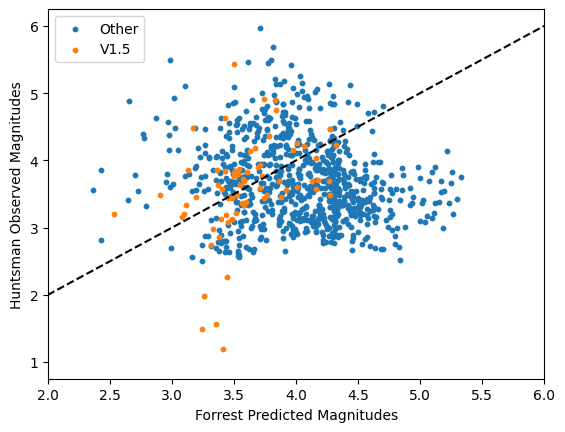

In [121]:
satellite_data['forrest_magnitudes'] = magnitudes_lab_brdfs

satellite_data_v1 = satellite_data[satellite_data['v_type']=='V1']
satellite_data_v15 = satellite_data[satellite_data['v_type']=='V1.5']

plt.scatter(x = satellite_data_v1['forrest_magnitudes'], y = satellite_data_v1['calibed_mags'], s = 10, label = 'Other')
plt.scatter(x = satellite_data_v15['forrest_magnitudes'], y = satellite_data_v15['calibed_mags'], s = 10, label = 'V1.5')
plt.legend()
plt.plot(np.linspace(1,6,100),np.linspace(1,6,100), c = 'black', ls = '--')
plt.xlim(2,6)
plt.xlabel("Forrest Predicted Magnitudes")
plt.ylabel("Huntsman Observed Magnitudes")
plt.savefig('/Users/physarah/Desktop/model_comparison4.png')

In [84]:
intensities_lab_brdfs_greenery = []

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_data['altitude2'], satellite_data['azimuth2'], satellite_data['sat_height'], satellite_data['datetimes_sat'])):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    intensities_lab_brdfs_greenery.append( \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=300,
            earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31))) # use the vegitation example that Forrest uses 
            #earth_brdf=lumos.brdf.library.LAMBERTIAN(0.8))
    # intensities_inferred_brdfs[i] = \
    #     lumos.calculator.get_intensity_observer_frame(
    #         starlink_v1p5.SURFACES_INFER_BRDFS,
    #         sat_h, sat_alt, sat_az, sun_alt, sun_az,
    #         include_earthshine = True,
    #         earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 

#magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
#magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
#magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

In [86]:
float_list = np.array([float(arr) for arr in intensities_lab_brdfs_greenery])
magnitudes_lab_brdfs_greenery = lumos.conversions.intensity_to_ab_mag(float_list)

In [88]:
satellite_data['forrest_magnitudes_green'] = magnitudes_lab_brdfs_greenery


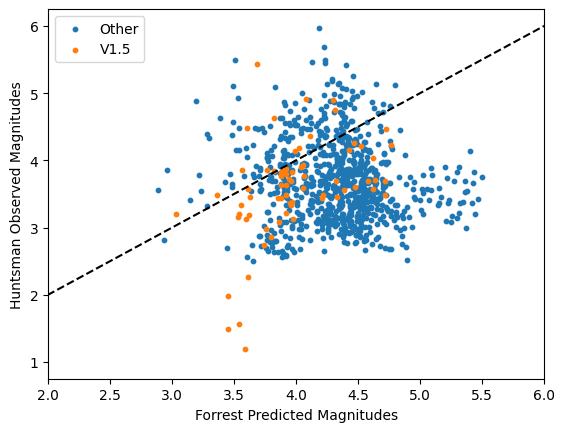

In [89]:

satellite_data_v1 = satellite_data[satellite_data['v_type']=='V1']
satellite_data_v15 = satellite_data[satellite_data['v_type']=='V1.5']

plt.scatter(x = satellite_data_v1['forrest_magnitudes_green'], y = satellite_data_v1['calibed_mags'], s = 10, label = 'Other')
plt.scatter(x = satellite_data_v15['forrest_magnitudes_green'], y = satellite_data_v15['calibed_mags'], s = 10, label = 'V1.5')
plt.legend()
plt.plot(np.linspace(1,6,100),np.linspace(1,6,100), c = 'black', ls = '--')
plt.xlim(2,6)
plt.xlabel("Forrest Predicted Magnitudes")
plt.ylabel("Huntsman Observed Magnitudes")
plt.savefig('/Users/physarah/Desktop/model_comparison2.png')

In [90]:
satellite_data

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,source_mean,source_median,source_sum,source_rate,sky_mean,sky_median,...,tle3,altitude2,azimuth2,forest_time,line_distance,sat_height,longitude,latitude,forrest_magnitudes,forrest_magnitudes_green
0,0,0,0,0,40088.034492,39851.885018,1.523391e+07,4.176246e+06,39646.573047,39607.401736,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,67.924527,66.582436,2024-01-18 06:31:22.517000+00:00,204.055336,550866.120023,153.118479,-33.021993,3.139481,3.034057
1,1,1,1,1,40026.502876,39773.284445,1.521126e+07,4.170034e+06,39547.232800,39538.464431,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,67.474004,66.068600,2024-01-18 06:31:23.251000+00:00,208.619186,550852.592118,153.154505,-32.989585,3.965312,3.863055
2,2,2,2,2,39998.665762,39776.578057,1.520308e+07,4.167794e+06,39573.237105,39603.447053,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,66.940026,65.486548,2024-01-18 06:31:24.123000+00:00,214.061905,550836.518301,153.197267,-32.951068,4.018646,3.917509
3,3,3,3,3,40259.760369,39916.365567,1.529971e+07,4.194283e+06,39613.266684,39615.050808,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,66.491776,65.018991,2024-01-18 06:31:24.857000+00:00,218.659630,550822.986187,153.233231,-32.918633,3.843786,3.742284
4,4,4,4,4,41738.692847,41447.909022,1.586290e+07,4.172991e+06,41133.477728,41122.924689,...,2 52534 53.2164 36.1108 0001558 94.3609 265...,66.041143,64.567028,2024-01-18 06:31:25.597000+00:00,223.309079,550809.341552,153.269461,-32.885920,3.899882,3.799324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,893,893,75,75,56672.211484,56679.154791,2.154119e+07,7.933300e+06,56524.240433,56501.143108,...,2 57942 53.0564 47.0643 0002577 120.7942 239...,28.345930,46.037462,2024-01-18 07:18:49.909000+00:00,800.352689,519912.821254,156.995378,-28.620875,5.478445,5.426801
894,894,894,76,76,56983.010013,56924.003722,2.166115e+07,7.977479e+06,56856.610574,56817.235166,...,2 57942 53.0564 47.0643 0002577 120.7942 239...,28.160504,46.022448,2024-01-18 07:18:50.657000+00:00,805.407083,519899.075018,157.029000,-28.586257,5.488548,5.437172
895,895,895,77,77,57445.745330,57406.944528,2.183662e+07,8.042100e+06,57217.227462,57217.159424,...,2 57942 53.0564 47.0643 0002577 120.7942 239...,27.950585,46.005511,2024-01-18 07:18:51.511000+00:00,811.177852,519883.381999,157.067358,-28.546721,5.492630,5.441159
896,896,896,79,79,58253.116150,58239.354019,2.214154e+07,8.154399e+06,58063.019277,58047.983076,...,2 57942 53.0564 47.0643 0002577 120.7942 239...,27.560883,45.974234,2024-01-18 07:18:53.117000+00:00,822.030457,519853.873944,157.139407,-28.472334,5.518822,5.468151


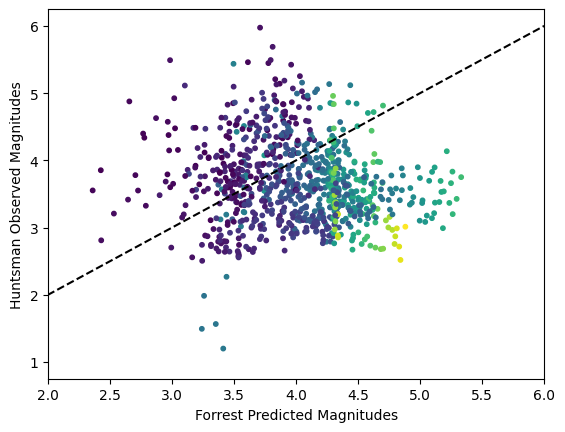

In [115]:
plt.scatter(x = satellite_data['forrest_magnitudes'], y = satellite_data['calibed_mags'], s = 10, c = satellite_data['airmass'])
plt.plot(np.linspace(1,6,100),np.linspace(1,6,100), c = 'black', ls = '--')
plt.xlim(2,6)
plt.xlabel("Forrest Predicted Magnitudes")
plt.ylabel("Huntsman Observed Magnitudes")
plt.savefig('/Users/physarah/Desktop/model_comparison3.png')

In [116]:
satellite_data.rename(columns={'forrest_magnitudes': 'forrest_magnitudes_lambertian_09'}, inplace=True)


In [118]:
df = satellite_data.drop(satellite_data.columns[:4], axis=1)


In [120]:
df.to_csv('/Users/physarah/Desktop/forrest_comparison_sat_data.csv')

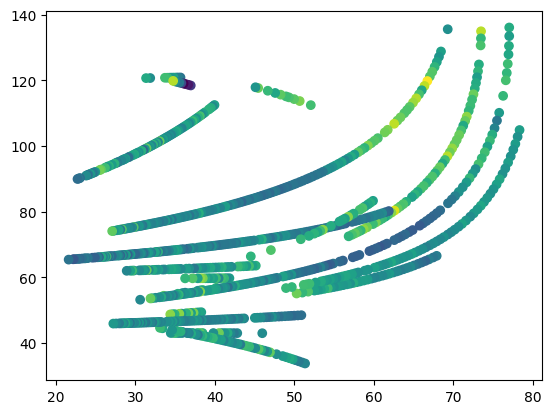

In [132]:
plt.scatter(satellite_data['altitude2'], satellite_data['azimuth2'], c = satellite_data['calibed_mags'])

[1.0, 0.0, 4.898587196589413e-17]
[6.123233995736766e-17, 1.0, 4.898587196589413e-17]
[-1.0, 1.2246467991473532e-16, 4.898587196589413e-17]
[-1.8369701987210297e-16, -1.0, 4.898587196589413e-17]


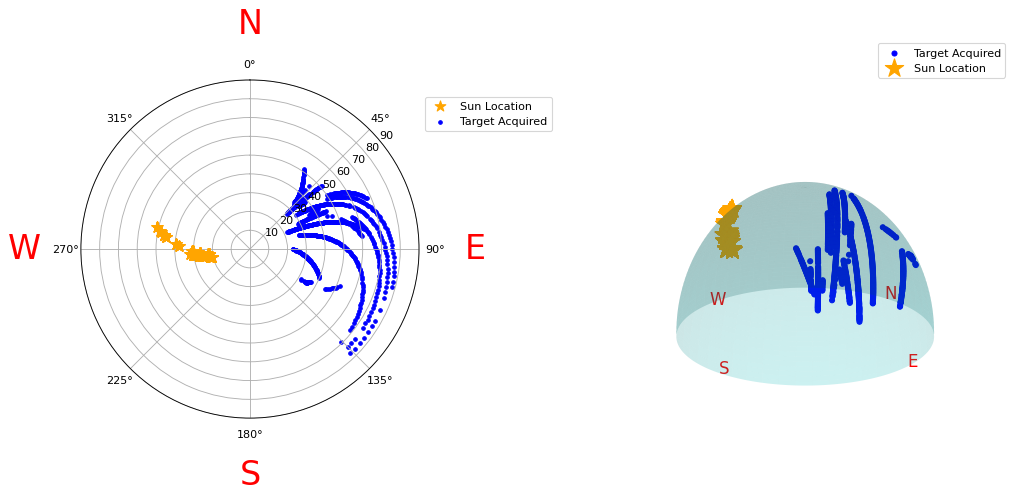

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook

%matplotlib inline


altitude_rad = np.array((satellite_data['altitude2'].to_list()*u.deg))
azimuth_rad = np.array((satellite_data['azimuth2'].to_list()*u.deg).to(u.rad))

# Create a polar plot
fig = plt.figure(figsize=(15, 8), dpi=80)

ax = plt.subplot(1,2,1,  projection='polar')

# Plot satellite transit path on the polar plot
#ax.plot(np.deg2rad(azimuths_line), (altitudes_line), color='black', label='Satellite Transit Path')

ax.scatter(np.deg2rad(satellite_data['sun_az']), (satellite_data['sun_alt']), 
           color='orange', s=100, label='Sun Location', zorder=10, marker='*')
ax.scatter(np.deg2rad(satellite_data['azimuth2']), satellite_data['altitude2'], 
           color='blue', label = "Target Acquired", s = 10)

# Plot cardinal directions
cardinal_directions = {'N': 0, 'E': np.pi / 2, 'S': np.pi, 'W': 3 * np.pi / 2}
for direction, angle in cardinal_directions.items():
    ax.text(angle, 120, direction, fontsize=30, color='r', ha='center', va='center')

# Set polar plot labels
ax.set_theta_direction(-1)  # Clockwise direction
ax.set_theta_offset(np.pi / 2)  # Set 0 degree at the top
ax.set_rlabel_position(50)  # Radial labels on the edge
ax.invert_yaxis()
ax.set_ylim(0,90)
# Add a legend
#ax.legend(loc = "upper right")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.9))

###############################################################################################################################
#df2 = df2[df2['calibed_mags']<6]

# Sample data (replace with your actual data)
altitude = [30, 60, 90, 45, 30]  # Example altitude values in degrees
azimuth = [45, 90, 180, 270, 360]  # Example azimuth values in degrees

# Convert altitude and azimuth to radians
altitude_rad = np.array((satellite_data['altitude2'].to_list()*u.deg).to(u.rad))
azimuth_rad = np.array((satellite_data['azimuth2'].to_list()*u.deg).to(u.rad))
    
# Create a 3D plot with polar projection for azimuth
ax = plt.subplot(1,2,2,  projection='3d')
ax.view_init(elev=20, azim=0+40)

# Plot hemisphere surface
phi, theta = np.mgrid[0.0:0.5*np.pi:1000j, 0.0:2.0*np.pi:1000j]
#phi, theta = np.mgrid[0.0:np.pi:1000j, 0.0:2.0*np.pi:1000j]

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = 0.8*np.cos(phi)
ax.plot_surface(x, y, z, color='c', alpha=0.2)

# Plot satellite transit on the hemisphere
x_transit = np.sin(np.pi / 2 - altitude_rad) * np.cos(azimuth_rad)
y_transit = np.sin(np.pi / 2 - altitude_rad) * np.sin(azimuth_rad)
z_transit = np.cos(np.pi / 2 - altitude_rad)
ax.scatter(x_transit, y_transit, 0.8*z_transit, color='b', label='Target Acquired', alpha = 1, marker = 'o')

# # Plot satellite transit on the hemisphere
# x_transit = np.sin(np.pi / 2 - np.array(np.deg2rad(altitudes_line))) * np.cos(np.deg2rad(np.array(azimuths_line)))
# y_transit = np.sin(np.pi / 2 - np.array(np.deg2rad(altitudes_line))) * np.sin(np.deg2rad(np.array(azimuths_line)))
# z_transit = np.cos(np.pi / 2 - np.array(np.deg2rad(altitudes_line)))
# ax.plot(x_transit, y_transit, 0.8*z_transit, color='black', label='Satellite Transit Path')

x_transit_sun = np.sin(np.pi / 2 - (np.deg2rad(satellite_data['sun_alt']))) * np.cos(np.deg2rad((satellite_data['sun_az'])))
y_transit_sun = np.sin(np.pi / 2 - (np.deg2rad(satellite_data['sun_alt']))) * np.sin(np.deg2rad((satellite_data['sun_az'])))
z_transit_sun = np.cos(np.pi / 2 - (np.deg2rad(satellite_data['sun_alt'])))
ax.scatter(x_transit_sun, y_transit_sun, 0.8*z_transit_sun, color='orange', s=300, label='Sun Location', zorder = 10, marker = '*')


azes = np.array(([0,90,180,270]*u.deg).to(u.rad).value)
alts = np.array(([0,0,0,0]*u.deg).to(u.rad).value)
x_transit = np.sin(np.pi / 2 - alts) * np.cos(azes)
y_transit = np.sin(np.pi / 2 - alts) * np.sin(azes)
z_transit = 0.8*np.cos(np.pi / 2 - alts)
# direction = ['N', 'E', 'S', 'W']
# ax.text(x_transit, y_transit, z_transit, direction, color='r', ha='center', va='center', fontsize=8)#, rotation=90)

# Plot cardinal directions
cardinal_directions = {'S': [x_transit[0],y_transit[0],z_transit[0]],
                       'E': [x_transit[1],y_transit[1],z_transit[1]],
                       'N': [x_transit[2],y_transit[2],z_transit[2]],
                       'W': [x_transit[3],y_transit[3],z_transit[3]]} # I SWAPPED THIS - BE CAREFUL
for direction, angle in cardinal_directions.items():
    print(angle)
    ax.text(angle[0], angle[1], angle[2], direction, fontsize=15, color='r')

    
# Set plot limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add a legend
ax.legend()
ax.axis(False)
# Show the plot
#plt.savefig("/Users/physarah/Desktop/sat_path.png")

plt.savefig('/Users/physarah/Desktop/all_sats.png')

(6.0, 1.0)

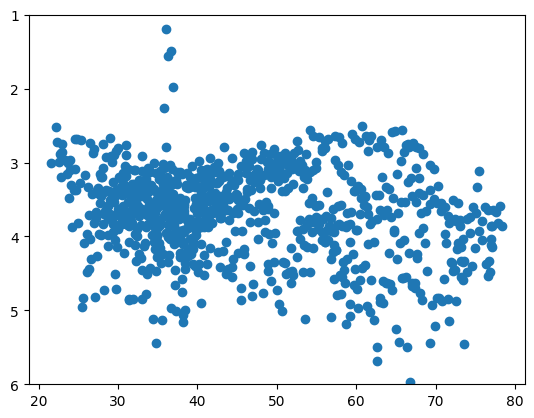

In [136]:
plt.scatter(satellite_data['altitude2'], satellite_data['calibed_mags'])
plt.ylim(6,1)

In [140]:
satellite_data.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0',
       'source_mean', 'source_median', 'source_sum', 'source_rate', 'sky_mean',
       'sky_median', 'sky_sum', 'sky_rate', 'target_mean', 'target_median',
       'target_sum', 'target_rate', 'sc_area', 'bk_area', 'exposure_time',
       'datetimes_sat', 'gains_sat', 'airmass', 'm_inst', 'm_inst_sky',
       'calibed_mags', 'altitude', 'azimuth', 'utc', 'zenith_angle',
       'km_distance', 'sunsep', 'sat_name', 'norad_id', 'v_type',
       'tle_filename', 'tle1', 'tle2', 'tle3', 'altitude2', 'azimuth2',
       'forest_time', 'line_distance', 'sat_height', 'longitude', 'latitude',
       'forrest_magnitudes_lambertian_09', 'forrest_magnitudes_green',
       'forrest_magnitudes', 'sun_alt', 'sun_az'],
      dtype='object')

In [173]:
satellite_data.to_csv('/Users/physarah/Desktop/good_satellite_data.csv')

In [178]:
satellite_data[satellite_data['v_type']=="V1.5"]['norad_id'].unique()

array([52534, 51104, 50837])

In [192]:
satellite_data[satellite_data['norad_id']==53162]['v_type']

133    V1
134    V1
135    V1
136    V1
137    V1
138    V1
139    V1
140    V1
Name: v_type, dtype: object

In [188]:
satellite_data['norad_id'].unique()

array([52534, 57874, 48587, 51104, 50837, 53162, 53741, 56427, 57938,
       48589, 56419, 58221, 58139, 48579, 56305, 56298, 50841, 57942])

In [213]:
condition = satellite_data['norad_id'] == 58139

satellite_data.loc[condition, 'v_type'] = 'V2.0 mini'

In [214]:
satellite_data

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,source_mean,source_median,source_sum,source_rate,sky_mean,sky_median,...,forest_time,line_distance,sat_height,longitude,latitude,forrest_magnitudes_lambertian_09,forrest_magnitudes_green,forrest_magnitudes,sun_alt,sun_az
0,0,0,0,0,40088.034492,39851.885018,1.523391e+07,4.176246e+06,39646.573047,39607.401736,...,2024-01-18 06:31:22.517000+00:00,204.055336,550866.120023,153.118479,-33.021993,2.530216,3.034057,2.530216,30.473570,264.357116
1,1,1,1,1,40026.502876,39773.284445,1.521126e+07,4.170034e+06,39547.232800,39538.464431,...,2024-01-18 06:31:23.251000+00:00,208.619186,550852.592118,153.154505,-32.989585,3.448659,3.863055,3.448659,30.471040,264.355565
2,2,2,2,2,39998.665762,39776.578057,1.520308e+07,4.167794e+06,39573.237105,39603.447053,...,2024-01-18 06:31:24.123000+00:00,214.061905,550836.518301,153.197267,-32.951068,3.514300,3.917509,3.514300,30.468034,264.353723
3,3,3,3,3,40259.760369,39916.365567,1.529971e+07,4.194283e+06,39613.266684,39615.050808,...,2024-01-18 06:31:24.857000+00:00,218.659630,550822.986187,153.233231,-32.918633,3.313224,3.742284,3.313224,30.465504,264.352172
4,4,4,4,4,41738.692847,41447.909022,1.586290e+07,4.172991e+06,41133.477728,41122.924689,...,2024-01-18 06:31:25.597000+00:00,223.309079,550809.341552,153.269461,-32.885920,3.380306,3.799324,3.380306,30.462953,264.350609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,893,893,75,75,56672.211484,56679.154791,2.154119e+07,7.933300e+06,56524.240433,56501.143108,...,2024-01-18 07:18:49.909000+00:00,800.352689,519912.821254,156.995378,-28.620875,5.248771,5.426801,5.248771,20.725392,258.460990
894,894,894,76,76,56983.010013,56924.003722,2.166115e+07,7.977479e+06,56856.610574,56817.235166,...,2024-01-18 07:18:50.657000+00:00,805.407083,519899.075018,157.029000,-28.586257,5.260467,5.437172,5.260467,20.722853,258.459455
895,895,895,77,77,57445.745330,57406.944528,2.183662e+07,8.042100e+06,57217.227462,57217.159424,...,2024-01-18 07:18:51.511000+00:00,811.177852,519883.381999,157.067358,-28.546721,5.262483,5.441159,5.262483,20.719955,258.457703
896,896,896,79,79,58253.116150,58239.354019,2.214154e+07,8.154399e+06,58063.019277,58047.983076,...,2024-01-18 07:18:53.117000+00:00,822.030457,519853.873944,157.139407,-28.472334,5.294362,5.468151,5.294362,20.714504,258.454409


In [216]:
satellite_data.to_csv("/Users/physarah/Desktop/good_satellite_data.csv")

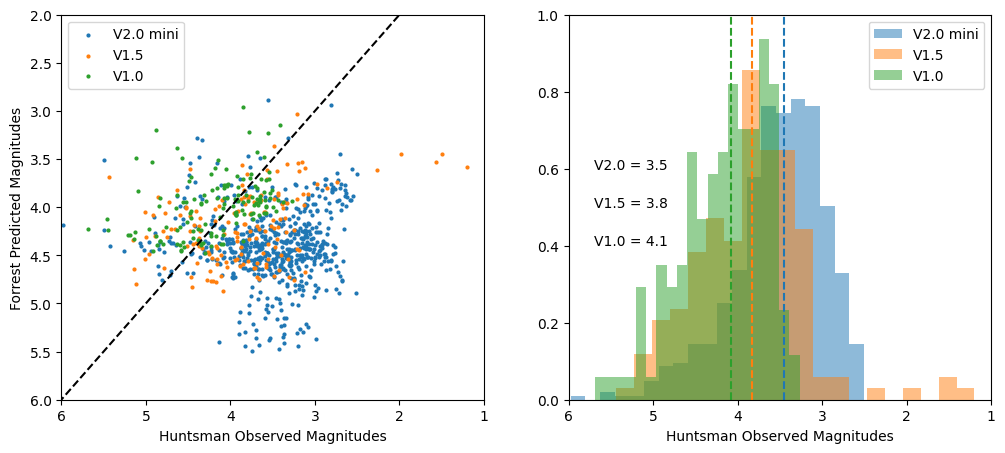

In [275]:
satellite_data_v1 = satellite_data[satellite_data['v_type']=='V1.0']
satellite_data_v15 = satellite_data[satellite_data['v_type']=='V1.5']
satellite_data_v2 = satellite_data[satellite_data['v_type']=='V2.0 mini']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y = satellite_data_v2['forrest_magnitudes_green'], 
            x = satellite_data_v2['calibed_mags'], s = 4, label = 'V2.0 mini')
plt.scatter(y = satellite_data_v15['forrest_magnitudes_green'], 
            x = satellite_data_v15['calibed_mags'], s = 4, label = 'V1.5')
plt.scatter(y = satellite_data_v1['forrest_magnitudes_green'], 
            x = satellite_data_v1['calibed_mags'], s = 4, label = 'V1.0')
plt.legend()
plt.plot(np.linspace(1,6,100),np.linspace(1,6,100), c = 'black', ls = '--')
plt.ylim(6,2)
plt.xlim(6,1)

plt.ylabel("Forrest Predicted Magnitudes")
plt.xlabel("Huntsman Observed Magnitudes")


plt.subplot(1,2,2)
plt.hist(satellite_data_v2['calibed_mags'], density = True, label = 'V2.0 mini', alpha = 0.5, bins = 20)
plt.hist(satellite_data_v15['calibed_mags'], density = True, label = 'V1.5', alpha = 0.5, bins = 20)
plt.hist(satellite_data_v1['calibed_mags'], density = True, label = 'V1.0', alpha = 0.5, bins = 20)
plt.axvline(np.median(satellite_data_v2['calibed_mags']), color = 'C0', ls = '--')
plt.axvline(np.median(satellite_data_v15['calibed_mags']), color = 'C1', ls = '--')
plt.axvline(np.median(satellite_data_v1['calibed_mags']), color = 'C2', ls = '--')
plt.xlabel("Huntsman Observed Magnitudes")

plt.text(5.7, 0.6, f"V2.0 = {round(np.median(satellite_data_v2['calibed_mags']),1)}")
plt.text(5.7, 0.5, f"V1.5 = {round(np.median(satellite_data_v15['calibed_mags']),1)}")
plt.text(5.7, 0.4, f"V1.0 = {round(np.median(satellite_data_v1['calibed_mags']),1)}")

plt.legend()
plt.xlim(6,1)
plt.ylim(0,1)

plt.savefig('/Users/physarah/Desktop/for_forrest.png')

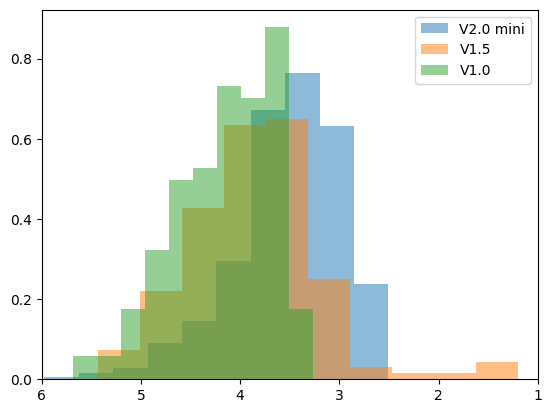

In [230]:
plt.hist(satellite_data_v2['calibed_mags'], density = True, label = 'V2.0 mini', alpha = 0.5)
plt.hist(satellite_data_v15['calibed_mags'], density = True, label = 'V1.5', alpha = 0.5)
plt.hist(satellite_data_v1['calibed_mags'], density = True, label = 'V1.0', alpha = 0.5)
plt.legend()
plt.xlim(6,1)
plt.savefig('/Users/physarah/Desktop/model_comparison11.png')

In [280]:
satellite_data_v2[satellite_data_v2['norad_id']==56305]

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,source_mean,source_median,source_sum,source_rate,sky_mean,sky_median,...,forest_time,line_distance,sat_height,longitude,latitude,forrest_magnitudes_lambertian_09,forrest_magnitudes_green,forrest_magnitudes,sun_alt,sun_az
605,605,605,0,0,46071.774963,46001.280676,1.751061e+07,5.534597e+06,45792.851145,45793.337804,...,2024-01-29 07:07:11.586000+00:00,196.784985,571140.143360,152.620153,-35.028236,3.997716,4.476854,3.997716,22.403670,262.682643
606,606,606,1,1,45296.014100,45182.127813,1.721909e+07,5.442458e+06,45102.100398,45086.727084,...,2024-01-29 07:07:15.412000+00:00,205.430259,571098.151775,152.863714,-34.919306,3.185923,3.708388,3.185923,22.390522,262.674489
607,607,607,2,2,44975.533547,44889.695328,1.709535e+07,5.403348e+06,44715.410994,44709.642516,...,2024-01-29 07:07:16.381000+00:00,208.049548,571087.487196,152.925291,-34.891629,3.901506,4.374368,3.901506,22.387192,262.672424
608,608,608,3,3,44716.326799,44644.226688,1.699626e+07,5.372026e+06,44512.571239,44500.533692,...,2024-01-29 07:07:17.349000+00:00,210.827372,571076.821801,152.986761,-34.863945,3.738471,4.222516,3.738471,22.383865,262.670362
609,609,609,4,4,44419.285412,44373.843447,1.688145e+07,5.335738e+06,44283.758595,44293.926095,...,2024-01-29 07:07:18.303000+00:00,213.716581,571066.299134,153.047299,-34.836628,4.012502,4.468723,4.012502,22.380587,262.668329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,726,726,123,123,55857.359906,55834.884013,2.123172e+07,1.027662e+07,55659.161351,55630.755136,...,2024-01-29 07:09:11.646000+00:00,869.604586,569745.801401,159.944261,-31.362533,4.638905,4.709581,4.638905,21.991192,262.426938
727,727,727,124,124,55953.139038,55954.335404,2.126937e+07,1.035390e+07,55881.194311,55888.502756,...,2024-01-29 07:09:12.608000+00:00,875.809383,569734.093121,160.000363,-31.331238,4.658694,4.723745,4.658694,21.987888,262.424890
728,728,728,125,125,56384.135428,56380.770186,2.143117e+07,1.043266e+07,56309.743781,56283.555756,...,2024-01-29 07:09:13.667000+00:00,882.642354,569721.196448,160.062076,-31.296755,4.677408,4.737432,4.677408,21.984251,262.422636
729,729,729,127,127,43186.034170,43152.161115,1.641472e+07,1.014842e+07,43078.184593,43013.951412,...,2024-01-29 07:09:15.477000+00:00,894.326978,569699.135136,160.167443,-31.237740,4.696369,4.752819,4.696369,21.978035,262.418783
